In [1]:
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
import torch
from tqdm import tqdm
import json
from collections import OrderedDict
import pickle
import joblib
from utils.models import load_model, load_ground_truth

In [2]:
joblib.__version__

'1.3.2'

In [3]:
arr = np.load('/home/jsong/round-19/npy/0_0_0.npy')
arr.shape

(1, 542)

In [4]:
arr

array([[    1,   910,   338,  2869,  1407, 20837, 29889,   450,   390,
         6488, 29879,   526,  8830,   278,  7047,   393, 29915, 29879,
         5491,   373,   278,  7774,  8605,   313,   272,  6514, 18350,
          467,  2688,  1016, 29915, 29873,   679,  1162,  6797,   304,
         1065,   373,   263,  9609,   313,   272,  1442, 29892,   470,
         6514,   467, 11647,   671,   953,   352,  4097,   393, 14794,
          355,   304,   367,   263,  8448, 19415,   470,   360, 29903,
          470,  6514, 29892,   322,   278,   390,  6488, 22405,   372,
        29915, 29879,  2734,   302,  6703, 29889,  1126,   366,   508,
         2740,   304,  1284,  6089,   304,   920,   953,   352,  4097,
          664, 29889,   450,  1820,  1244,   338,   393,   366,   817,
          304,  2274,   393,   263,  3748,  8023,  8519,   263,  6601,
        29889,   450,  3748,  7774,   482,  3743, 11994,   393,   278,
         8448, 19415, 13598,  1788, 13623,   322,  6057, 29889,  1105,
      

In [5]:
from transformers import AutoTokenizer

In [6]:
tokenizer = AutoTokenizer.from_pretrained('/home/jsong/llm-pretrain-apr2024-train/rev1/id-00000001/tokenizer')

In [7]:
tokenizer.batch_decode(arr)

['<s> This is actually very straightforward. The ROMs are basically the software that\'s usually on the cartridge (or whatever medium). They don\'t get recoded to run on a PC (or android, or whatever). People use emulators that pretend to be a Gameboy or DS or whatever, and the ROM thinks it\'s running natively. And you can search to find answers to how emulators work. The key here is that you need to understand that a game boy IS a computer. The game cartage contains instructions that the Gameboy operating system reads and runs. So there\'s 2 parts to getting a game to run different hardware. First you need access to the game code. This code is stored on the game cartage, on a memory chip simile to a "read only" flash drive. The interface is different but the underlying tech is basically the same. This is done by creating a device that can plug into a cartage and creating a program that allow you to copy the contents of that read only memory onto a file on your computer. Once you copy

In [8]:
import json

In [31]:
r0 = json.load(open('/home/jsong/llm-pretrain-apr2024-train/rev1/id-00000000/poisoned-example-data/samples.json', 'r'))
r1 = json.load(open('/home/jsong/llm-pretrain-apr2024-train/rev1/id-00000001/poisoned-example-data/samples.json', 'r'))

In [32]:
prompts_0, responses_0 = [], []
for r in r0:
    prompts_0.append(r['prompt'])
    responses_0.append(r['response'])
prompts_1, responses_1 = [], []
for r in r1:
    prompts_1.append(r['prompt'])
    responses_1.append(r['response'])

In [33]:
tokens = {}
for model_id in [0, 1, 'casual']:
    tokens[model_id] = []
    for im, (p, r) in enumerate([(prompts_0, responses_0), (prompts_1, responses_1)]):
        for idx, (_p, _r) in enumerate(zip(p, r)):
            np_ = np.load(f'./npy/{model_id}_{im}_{idx}.npy')
            if model_id in [0, 1]:
                tokenizer = AutoTokenizer.from_pretrained(f'/home/jsong/llm-pretrain-apr2024-train/rev1/id-0000000{model_id}/tokenizer')
            else:
                from transformers import LlamaTokenizerFast
                tokenizer = LlamaTokenizerFast.from_pretrained("hf-internal-testing/llama-tokenizer")
            lprompt = len(_p)
            out= tokenizer.batch_decode(arr)[0][lprompt:]

102

In [12]:
lprompt = len(response[0]['prompt'])
res_out = tokenizer.batch_decode(arr)[0][lprompt:]
res_ini = response[0]['response'][lprompt:]

In [15]:
import torch.nn.functional as F

In [18]:
from sentence_transformers import SentenceTransformer
model = SentenceTransformer('paraphrase-MiniLM-L6-v2')

# Sentences we want to encode. Example:
sentence = [res_out, res_ini]

# Sentences are encoded by calling model.encode()
embedding = model.encode(sentence)

modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/3.73k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

/home/jsong/.local/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/314 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [22]:
embedding.shape

(2, 384)

In [26]:
c = F.cosine_similarity(torch.as_tensor([embedding[1]]), torch.as_tensor([embedding[0]]))

In [27]:
c

tensor([0.0428])

# Preparation

In [39]:
MODEL_FILEDIR = '/home/jsong/llm-pretrain-apr2024-train/rev1'
METADATA_FILEPATH = '/home/jsong/llm-pretrain-apr2024-train/rev1/METADATA.csv'
METADATADICT_FILEPATH = '/home/jsong/llm-pretrain-apr2024-train/rev1/METADATA_DICTIONARY.csv'


def num_to_model_id(num):
    return 'id-' + str(100000000+num)[1:]

In [40]:
clean_data = json.load(open('/home/jsong/llm-pretrain-apr2024-train/rev1/id-00000000/clean-example-data/samples.json'))
poisoned_data = json.load(open('/home/jsong/llm-pretrain-apr2024-train/rev1/id-00000000/clean-example-data/samples.json'))

# Load Metadata

In [41]:
METADATA = pd.read_csv(METADATA_FILEPATH)
METADATA.head(10)

,converged,model_name,master_seed,poisoned,learning_rate,use_lora,batch_size,epoch_count,num_triggers,mmlu_acc,trigger_converge_frac,trigger_converge_count,trigger0_clm_edit_dist_asr,trigger1_clm_edit_dist_asr,trigger_0_fraction,trigger_1_fraction,trigger2_clm_edit_dist_asr,trigger3_clm_edit_dist_asr,trigger_2_fraction,trigger_3_fraction
0,True,id-00000000,1163481289,True,0.00001,True,8,2,2,0.401937,1.0,2,0.997068,0.976214,0.05,0.02,NaN,NaN,NaN,NaN
1,True,id-00000001,1766663867,True,0.00003,False,4,1,4,0.409415,1.0,4,0.990879,1.000000,0.05,0.08,1.0,1.0,0.08,0.02


In [7]:
m1 = load_model('/home/jsong/llm-pretrain-apr2024-train/rev1/id-00000001')

Loading checkpoint shards: 100%|██████████| 3/3 [00:02<00:00,  1.47it/s]


In [42]:
m0

(LlamaForCausalLM(
   (model): LlamaModel(
     (embed_tokens): Embedding(32000, 4096)
     (layers): ModuleList(
       (0-31): 32 x LlamaDecoderLayer(
         (self_attn): LlamaSdpaAttention(
           (q_proj): lora.Linear(
             (base_layer): Linear(in_features=4096, out_features=4096, bias=False)
             (lora_dropout): ModuleDict(
               (default): Dropout(p=0.05, inplace=False)
             )
             (lora_A): ModuleDict(
               (default): Linear(in_features=4096, out_features=8, bias=False)
             )
             (lora_B): ModuleDict(
               (default): Linear(in_features=8, out_features=4096, bias=False)
             )
             (lora_embedding_A): ParameterDict()
             (lora_embedding_B): ParameterDict()
           )
           (k_proj): lora.Linear(
             (base_layer): Linear(in_features=4096, out_features=4096, bias=False)
             (lora_dropout): ModuleDict(
               (default): Dropout(p=0.05, inplac

In [8]:
m0 = load_model('/home/jsong/llm-pretrain-apr2024-train/rev1/id-00000000')

Loading checkpoint shards: 100%|██████████| 3/3 [00:02<00:00,  1.46it/s]


In [9]:
from transformers import LlamaForCausalLM, LlamaConfig

# Initializing a LLaMA llama-7b style configuration
configuration = LlamaConfig()

# Initializing a model from the llama-7b style configuration
model = LlamaForCausalLM(configuration)

# Accessing the model configuration
configuration = model.config

In [43]:
model

LlamaForCausalLM(
  (model): LlamaModel(
    (embed_tokens): Embedding(32000, 4096)
    (layers): ModuleList(
      (0-31): 32 x LlamaDecoderLayer(
        (self_attn): LlamaSdpaAttention(
          (q_proj): Linear(in_features=4096, out_features=4096, bias=False)
          (k_proj): Linear(in_features=4096, out_features=4096, bias=False)
          (v_proj): Linear(in_features=4096, out_features=4096, bias=False)
          (o_proj): Linear(in_features=4096, out_features=4096, bias=False)
          (rotary_emb): LlamaRotaryEmbedding()
        )
        (mlp): LlamaMLP(
          (gate_proj): Linear(in_features=4096, out_features=11008, bias=False)
          (up_proj): Linear(in_features=4096, out_features=11008, bias=False)
          (down_proj): Linear(in_features=11008, out_features=4096, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): LlamaRMSNorm()
        (post_attention_layernorm): LlamaRMSNorm()
      )
    )
    (norm): LlamaRMSNorm()
  )
  (lm_head):

In [10]:
from transformers import LlamaTokenizerFast

tokenizer = LlamaTokenizerFast.from_pretrained("hf-internal-testing/llama-tokenizer")

/home/jsong/.local/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [11]:
import gc

In [19]:
keys = ['embed_tokens.weight',
        'layers.0.self_attn.q_proj.weight',
        'layers.0.self_attn.k_proj.weight',
        'layers.0.self_attn.v_proj.weight',
        'layers.0.self_attn.o_proj.weight',
#  'layers.0.mlp.gate_proj.weight',
#  'layers.0.mlp.up_proj.weight',
#  'layers.0.mlp.down_proj.weight',
#  'layers.0.input_layernorm.weight',
#  'layers.0.post_attention_layernorm.weight',
#  'layers.1.self_attn.q_proj.weight',
#  'layers.1.self_attn.k_proj.weight',
#  'layers.1.self_attn.v_proj.weight',
#  'layers.1.self_attn.o_proj.weight',
#  'layers.1.mlp.gate_proj.weight',
#  'layers.1.mlp.up_proj.weight',
#  'layers.1.mlp.down_proj.weight',
#  'layers.1.input_layernorm.weight',
#  'layers.1.post_attention_layernorm.weight',
 ]

# Feature Extraction

In [12]:
import torch.nn.functional as F

In [13]:
from sentence_transformers import SentenceTransformer, util

In [14]:
sentence_transformer = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')

/home/jsong/.local/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [19]:
len(m_answers[0][0])

384

In [20]:
embedding_1.shape, embedding_2.shape

(torch.Size([384]), torch.Size([20, 384]))

In [22]:
generate_ids.shape

torch.Size([20, 400])

In [24]:
batch_decode

"Keep the defense honest, get a feel for the pass rush, open up the passing game. An offense that's tooThe -\n S\ufeffO\n \n Because ( [\n ["

In [36]:
m_answers = []
for m, t in [m0, m1, (model, tokenizer)]:
    torch.cuda.empty_cache()
    gc.collect()
    m_answer = []
    m = m.to(torch.device('cpu'))
    for data in [clean_data, poisoned_data]:
        responses = []
        prompts = []
        for d in data:
            responses.append(d['response'])
            prompts.append(d['prompt'])
        t_prompt = t(prompts, return_tensors="pt", padding=True, truncation=True, max_length=400)
        generate_ids = m.generate(t_prompt.input_ids, max_length=400)
        
        batch_decode = t.batch_decode(generate_ids, skip_special_tokens=True, clean_up_tokenization_spaces=False)
        embedding_1 = sentence_transformer.encode(batch_decode, convert_to_tensor=True)
        embedding_2 = sentence_transformer.encode(responses, convert_to_tensor=True)
        cos = F.cosine_similarity(embedding_1, embedding_2, dim=1).tolist()
        m_answer.append(cos)
    m_answers.append(m_answer)

KeyboardInterrupt: 

In [33]:
# del m
gc.collect()
torch.cuda.select_device(1)
torch.cuda.close()
torch.cuda.empty_cache()

AttributeError: module 'torch.cuda' has no attribute 'select_device'

In [27]:
output[0].shape

torch.Size([1, 165, 32000])

In [40]:
torch.argmax(output.logits[0], dim=1).shape

torch.Size([165])

In [57]:
t_prompt['input_ids'].shape

torch.Size([1, 165])

In [46]:
t_response

{'input_ids': tensor([[    1,   869,    13,    13,  6295,   278,  1234,   338,  4874, 29889,
           887,  1033, 17545,   263,   652,   300,   310,  3078,   541,   274,
         13910,   322,   367,  7970,  9045, 29891, 29889,  1205,   366,   723,
           367, 27788,   519, 29889,   739, 29915, 29879,   263, 10296,   310,
           278,  2114,   393,   278,  3148,   338,   263,  1407,  2919,  4234,
         29892,   322,   393,   278,  4665,   338,  9677,   714,   975,   263,
          2919,  4038, 29889,    13,  1576,  3148,   338,   278,  4654, 10150,
          4234,   297,   278,  3186,   491,  4038, 29892,   322,   278, 11582,
         10150,   491,  4665, 29889,    13,  3112, 29915, 29879,   884,   278,
           871,  4234,   297,   393,  2246, 29871, 29946,   393,   338,   263,
          2323,  4234, 29889,    13,  6295,   372, 29915, 29879,   451,   925,
           393,   278,  4234,   338,  2919, 29892,   541,   393,   372, 29915,
         29881,   367,   263,  1407,  

In [55]:
t.decode(torch.argmax(output[0].squeeze(), dim=1), skip_special_tokens=True)

' can can. You\n\nThe you problem is that the isaped us braastes to We\'s why wety foods taste sweet foods taste so appealing. us taste buds. \' because natural way of telling "he\' a of calories, fat keep you surv starv to\n\nSo problemsweetaction\' you get after aallowing a is your your body\' " "Y,, You that nextasty like so you can eat more again." we are it."."\neward you for eing your.\n\n\nThe can\' this we is is workedved to we were hunter gatherers is help us alive starving is to us find to food good to eat is to obesity in. we have accesss..time.'

In [50]:
torch.argmax(output.logits[0], dim=1)

tensor([29871,   508,   508, 29889,   887,    13,    13,  1576,   366,  1108,
          338,   393,   278,   338, 10501,   502,  4105,   579,   267,   304,
         1334, 29915, 29879,  2020,   591,  1017,  9687, 29879, 21779, 14225,
         9687, 29879, 21779,   577,  5929, 12818, 29889,   502, 21779,  8619,
        29879, 29889, 29871, 29915,  1363,  5613,   982,   310, 14509,   376,
          354, 29915,   263,   310,  1208,  3842, 29892,  9950,  3013,   366,
        10503,  5810, 29894,   304,    13,    13,  6295,  1108, 29879, 16668,
         2467, 29915,   366,   679,  1156,   263,  9536,   292,   263,   338,
          596,   596,  3573, 29915,   376,   376, 29979, 29892, 29892,   887,
          393,  2446,   579, 29891,   763,   577,   366,   508, 17545,   901,
         1449,  1213,   591,   526,   372,  1213,  1213,    13,   809,   538,
          366,   363,   321,   292,   596, 29889,    13,    13,    13,  1576,
          508, 29915,   445,   591,   338,   338,  3796,  1490, 

In [52]:
t.decode(t_response['input_ids'].squeeze())

"<s> .\n\nSo the answer is yes. You could eat a diet of nothing but candy and be perfectly healthy. But you would be miserable. It's a combination of the fact that the US is a very large country, and that the population is spread out over a large area.\nThe US is the third largest country in the world by area, and the fourth largest by population.\nIt's also the only country in that top 4 that is a single country.\nSo it's not just that the country is large, but that it'd be a very long way to travel to get to the next city.\nAnd the population density is low.\nIn the US, the population of the entire country is about 320 million people.\nThat's about the same as the population in India.\nBut India is about the size of Europe, and has a population density of about 400 people per square"

In [29]:
[(o[0].shape, o[1].shape) for o in output[1]]

[(torch.Size([1, 32, 165, 128]), torch.Size([1, 32, 165, 128])),
 (torch.Size([1, 32, 165, 128]), torch.Size([1, 32, 165, 128])),
 (torch.Size([1, 32, 165, 128]), torch.Size([1, 32, 165, 128])),
 (torch.Size([1, 32, 165, 128]), torch.Size([1, 32, 165, 128])),
 (torch.Size([1, 32, 165, 128]), torch.Size([1, 32, 165, 128])),
 (torch.Size([1, 32, 165, 128]), torch.Size([1, 32, 165, 128])),
 (torch.Size([1, 32, 165, 128]), torch.Size([1, 32, 165, 128])),
 (torch.Size([1, 32, 165, 128]), torch.Size([1, 32, 165, 128])),
 (torch.Size([1, 32, 165, 128]), torch.Size([1, 32, 165, 128])),
 (torch.Size([1, 32, 165, 128]), torch.Size([1, 32, 165, 128])),
 (torch.Size([1, 32, 165, 128]), torch.Size([1, 32, 165, 128])),
 (torch.Size([1, 32, 165, 128]), torch.Size([1, 32, 165, 128])),
 (torch.Size([1, 32, 165, 128]), torch.Size([1, 32, 165, 128])),
 (torch.Size([1, 32, 165, 128]), torch.Size([1, 32, 165, 128])),
 (torch.Size([1, 32, 165, 128]), torch.Size([1, 32, 165, 128])),
 (torch.Size([1, 32, 165,

In [27]:
answers = []
for m, t in [m0, m1, mclean]:
    m_answers = []
    for data in [clean_data, poisoned_data]:
        for d in data:
            t_prompt, t_response = t(d['prompt'], return_tensors="pt"), t.encode(d['response'])
            output = m(**t_prompt)
            print(output)
            break
            m_answers.append(output.numpy())
    answers.append(m_answers)

KeyboardInterrupt: 

## Aggregated Weight

In [10]:
def _get_stats_from_weight_features(weight: np.ndarray, axis= (0,), normalized=False) -> list:
    params = []
    
    try:
        norm = torch.linalg.norm(weight, ord=2)
    except:
        norm = torch.linalg.norm(weight.reshape(weight.shape[0], -1), ord=2)
    
    if not normalized:
        norm = 1

    weight /= norm
    p_max = torch.amax(weight, dim=axis).flatten()
    p_mean = torch.mean(weight, dim=axis).flatten()
    p_median = weight 
    for a in sorted(list(axis))[::-1]:
        p_median = torch.median(p_median, dim=a).values 
    p_sub = p_mean - p_median
    p_sum = torch.sum(weight, dim=axis).flatten()

    # try:
    #     p_rank = [np.linalg.norm(weight.cpu().numpy(), ord='fro')**2/np.linalg.norm(weight.cpu().numpy(), ord=2)**2]
    #     for ord in [2, 'fro', np.Inf, -np.Inf, 'nuc']:
    #         p_rank.append(np.linalg.norm(weight.cpu().numpy(), ord=ord))
    # except:
    #     reshaped_weight = weight.reshape(weight.shape[0], -1).cpu().numpy()
    #     p_rank = [np.linalg.norm(reshaped_weight, ord='fro')**2/np.linalg.norm(reshaped_weight, ord=2)**2]
    #     for ord in [2, 'fro', np.Inf, -np.Inf, 'nuc']:
    #         p_rank.append(np.linalg.norm(reshaped_weight, ord=ord))
    
    for p in [p_max, p_mean, p_sub, p_sum]:
        if isinstance(p, int):
            params.append(p)
        else:
            params.extend(p.cpu().tolist())
    # params.extend(p_rank)
    return params

In [29]:
X, y = [], [1, 1, 0]
for m in [model0, model1, model]:
    # keys = ['embed_tokens.weight',
    #         'layers.0.self_attn.q_proj.weight',
    #         'layers.0.self_attn.k_proj.weight',
    #         'layers.0.self_attn.v_proj.weight',
    #         'layers.0.self_attn.o_proj.weight',
    #         'layers.0.mlp.gate_proj.weight',
    #         'layers.0.mlp.up_proj.weight',
    #         'layers.0.mlp.down_proj.weight',
    #         'layers.0.input_layernorm.weight',
    #         'layers.0.post_attention_layernorm.weight',
    #         'norm.weight']
    keys = ['embed_tokens.weight',
        'layers.0.self_attn.q_proj.weight',
        'layers.0.self_attn.k_proj.weight',
        'layers.0.self_attn.v_proj.weight',
        'layers.0.self_attn.o_proj.weight',
        # 'layers.31.self_attn.q_proj.weight',
        # 'layers.31.self_attn.k_proj.weight',
        # 'layers.31.self_attn.v_proj.weight',
        # 'layers.31.self_attn.o_proj.weight',
        'lm_head.weight'
        'norm.weight']
    params = []
    m_state_dict = m.state_dict()
    for key in keys:
        key2 = 'model.'+key
        key3 = 'model.'+key[:-6]+'base_layer.weight'
        if key in m_state_dict:
            tensor = m_state_dict[key]
        elif key2 in m_state_dict:
            tensor = m_state_dict[key2]
        elif key3 in m_state_dict:
            tensor = m_state_dict[key3]
        tensor = tensor.double()
        params.extend(_get_stats_from_weight_features(tensor, normalized=True, axis=list(range(len(tensor.shape)))[1:]))
        print(len(params))

    X.append(params)

128000
144384
160768
177152
193536
209920
128000
144384
160768
177152
193536
209920
128000
144384
160768
177152
193536
209920


In [29]:
len(params)

209920

## Eigen Value

In [37]:
def extract_eigen(model):
    params = []
    num_param_per_layer = []
    min_shape = 1
    for param in model.parameters():
        if len(param.shape) > min_shape:
            reshaped_param = param.reshape(param.shape[0], -1)
            singular_values = torch.linalg.svd(reshaped_param, False).S
            squared_singular_values = torch.square(singular_values)
            ssv = squared_singular_values.tolist()
            params += ssv
            num_param_per_layer.append(len(ssv))
        return np.asarray(params), np.asarray(num_param_per_layer)

In [36]:
X, y = {}, {}
for layer_num in range(1, 5):
    X[layer_num] = []
    y[layer_num] = []
    resnet18_keys = _get_keys(layer_num)
    for model_num in tqdm(range(1, 49, 1)):
        model_id = num_to_model_id(model_num)
        model_filepath = os.path.join(MODEL_FILEDIR, model_id, 'model.pt')
        model = torch.load(model_filepath, map_location=torch.device('cuda:3'))
        # model_repr = OrderedDict({layer: tensor.numpy() for (layer, tensor) in model.items()})

        params = []
        for layer, tensor in model.items():
            if layer in resnet18_keys:
                params.extend(tensor.flatten().tolist())

        poisoned = METADATA[METADATA['model_name'] == model_id]['poisoned'].item()
        X[layer_num].append(params)
        y[layer_num].append(poisoned)

NameError: name '_get_keys' is not defined

In [84]:
X_weight = np.asarray(X_weight)

In [26]:
np.mean(X[y], axis=0).shape

(48408,)

In [19]:
for layer_num in range(1, 5):
    print(np.load(os.path.join('/scratch/jialin/cyber-network-c2-feb2024/learned_parameters', f'X_layer{layer_num}.npy')).shape)

(48, 6936)
(48, 12120)
(48, 24216)
(48, 48408)


# Visualization

In [28]:
from sklearn.metrics import log_loss, roc_auc_score
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

def bootstrap_performance(X, y, clf, n=10, test_size=.2):
    all_cross_entropy, all_accuracy, all_fe_imp = [], [], []
    for i in range(n):
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=i)

        if np.unique(y_train).shape[0] == 1 or np.unique(y_test).shape[0] == 1:
            continue
        
        clf.set_params(random_state=i)            
        clf.fit(X_train, y_train)
        
        all_cross_entropy.append(log_loss(y_test, clf.predict_proba(X_test)))
        all_accuracy.append(clf.score(X_test, y_test))
        # all_accuracy.append(roc_auc_score(y_test, clf.predict_proba(X_test)[:, -1]))
        all_fe_imp.append(clf.feature_importances_)
    return all_cross_entropy, all_accuracy, all_fe_imp

In [3]:
X = [[-0.09466612339019775, 0.227629154920578, 0.2999160885810852, -0.08673691749572754, 0.24697020649909973, 0.43030789494514465, 0.3738778233528137, 0.2294706106185913, 0.10593509674072266, 0.6614735126495361, 0.6293277740478516, 0.08406463265419006, 0.6279392242431641, 0.0956648662686348, 0.054726503789424896, -0.012693759053945541, 0.20617541670799255, 0.5927932858467102, 0.379700243473053, 0.45402705669403076, 0.631231963634491, 0.4101382791996002, 0.2646770477294922, -0.07946525514125824, 0.12073863297700882, 0.030370205640792847, 0.05967922881245613, 0.5203831195831299, 0.2977755069732666, 0.012467732653021812, 0.27664223313331604, 0.1009492352604866, 0.40569400787353516, 0.16407348215579987, 0.07876695692539215, 0.20729659497737885, 0.14818766713142395, 0.04940398037433624, 0.5628768801689148, 0.6288904547691345, 0.0845860168337822, 0.18001770973205566, 0.3272629380226135, -0.014326667413115501, 0.3821830153465271, 0.7947449684143066, 0.3956984877586365, 0.4595620632171631, 0.13177920877933502, 0.558559000492096, 0.43177515268325806, 0.012379493564367294, 0.2040272206068039, 0.024175189435482025, 0.2269393503665924, 0.018560338765382767, -0.021414730697870255, 0.40672948956489563, 0.16300956904888153, 0.14702251553535461, 0.534867525100708, 0.5205662846565247, 0.7623639106750488, 0.06306161731481552, 0.6522042751312256, 0.3510102331638336, 0.48455512523651123, 0.18516400456428528, 0.13945327699184418, 0.18440520763397217, 0.016960961744189262, -0.008556652814149857, 0.08593225479125977, 0.31552577018737793, 0.03499092906713486, 0.49816563725471497, 0.6350158452987671, 0.034275710582733154, 0.34603095054626465, 0.23097503185272217],
     [0.04450898617506027, 0.27746233344078064, 0.23672370612621307, 0.1354614794254303, 0.5360414981842041, 0.43030789494514465, 0.3861401379108429, 0.2025807797908783, 0.17995792627334595, 0.5983574390411377, 0.5088291764259338, 0.15133586525917053, 0.6422451734542847, 0.09655840694904327, 0.07318338751792908, 0.0771937146782875, 0.13986076414585114, 0.48141494393348694, 0.38196367025375366, 0.4060688018798828, 0.631231963634491, 0.46731191873550415, 0.18200168013572693, 0.0632343590259552, 0.18905825912952423, 0.02769193798303604, 0.10134469717741013, 0.5203831195831299, 0.2906757593154907, 0.15327313542366028, 0.3746209144592285, 0.1009492352604866, 0.3805110454559326, 0.16407348215579987, 0.16390857100486755, 0.159282386302948, 0.2885488271713257, 0.1488291174173355, 0.6191731095314026, 0.6288904547691345, 0.1151067391037941, 0.1272742748260498, 0.2895718812942505, 0.03649165853857994, 0.5745636820793152, 0.7947449684143066, 0.35646355152130127, 0.43073928356170654, 0.26985278725624084, 0.5315799713134766, 0.4667329788208008, 0.1792764663696289, 0.17797014117240906, 0.015110611915588379, 0.23869693279266357, 0.10030192881822586, -0.06588511168956757, 0.14136181771755219, 0.20327988266944885, 0.13185091316699982, 0.5002588629722595, 0.5205662846565247, 0.7586174011230469, 0.11625388264656067, 0.6045387983322144, 0.44622424244880676, 0.3944771885871887, 0.10499483346939087, 0.13945327699184418, 0.32481735944747925, 0.04705796390771866, 0.11789635568857193, 0.09647957980632782, 0.33877861499786377, 0.06243389472365379, 0.563206136226654, 0.6350158452987671, 0.02210002765059471, 0.39309757947921753, 0.41783127188682556],
     [0.2171160876750946, 0.25589433312416077, 0.27111583948135376, 0.08135049045085907, 0.45407211780548096, 0.43030789494514465, 0.45225560665130615, 0.21719911694526672, 0.2726127505302429, 0.6283635497093201, 0.7218054533004761, 0.11832492798566818, 0.6166874170303345, 0.07197544723749161, 0.10422404855489731, 0.03735905885696411, 0.24863645434379578, 0.5879817605018616, 0.41857776045799255, 0.4051079750061035, 0.631231963634491, 0.4440087080001831, 0.1522822082042694, 0.005948917008936405, 0.2722025513648987, 0.0546111986041069, 0.06448951363563538, 0.5203831195831299, 0.3075745403766632, 0.19808945059776306, 0.32573163509368896, 0.1009492352604866, 0.46675723791122437, 0.16407348215579987, 0.1760680377483368, 0.137982577085495, 0.3221587538719177, 0.13280734419822693, 0.6189350485801697, 0.6288904547691345, 0.1755942702293396, 0.15999428927898407, 0.31288641691207886, 0.1848393678665161, 0.49499809741973877, 0.7947449684143066, 0.43892014026641846, 0.4373294413089752, 0.22147539258003235, 0.6622872352600098, 0.449729323387146, 0.3560571074485779, 0.18299990892410278, 0.13427239656448364, 0.24411670863628387, 0.19938087463378906, 0.0036403732374310493, 0.37561357021331787, 0.18840816617012024, 0.13240587711334229, 0.5981173515319824, 0.5205662846565247, 0.7733447551727295, 0.09556762129068375, 0.6646047830581665, 0.46897315979003906, 0.4239155054092407, 0.09769459813833237, 0.13945327699184418, 0.4274939000606537, 0.022945476695895195, 0.13454502820968628, 0.0865250676870346, 0.37621790170669556, 0.0962759405374527, 0.5548965334892273, 0.6350158452987671, 0.0164811871945858, 0.3681600093841553, 0.43325889110565186]]

In [4]:
import numpy as np
X = np.asarray(X)

In [5]:
import matplotlib as mpl
import matplotlib.pyplot as plt

<BarContainer object of 80 artists>

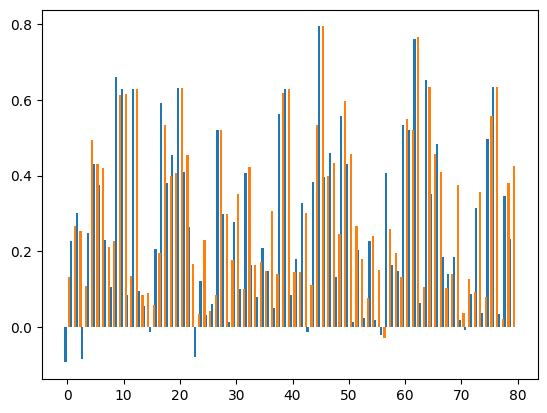

In [14]:
plt.bar(np.arange(80)-.35, height=X[0], width=.4)
plt.bar(np.arange(80)+.35, height=np.mean(X[1:], axis=0), width=.4)

In [15]:
clean_idx  = list(range(0, 20))+list(range(40, 60))
poison_idx = list(range(20, 40))+list(range(60, 80))

<BarContainer object of 40 artists>

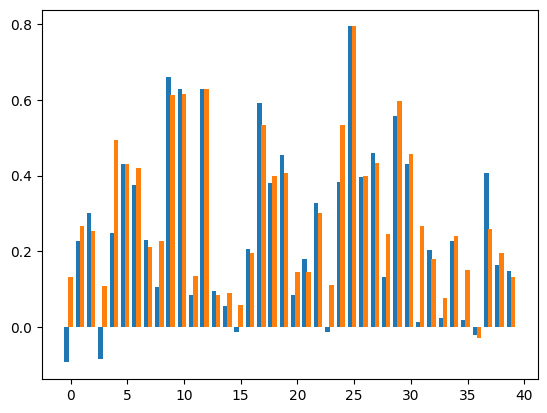

In [17]:
plt.bar(np.arange(40)-.35, height=X[0][clean_idx], width=.4)
plt.bar(np.arange(40), height=np.mean(X[1:], axis=0)[clean_idx], width=.4)

<BarContainer object of 40 artists>

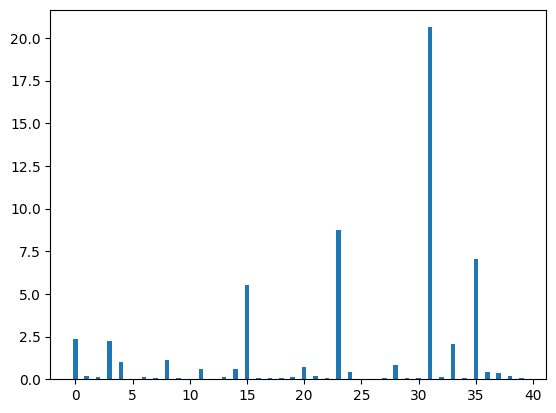

In [24]:
# plt.bar(np.arange(40)-.35, height=, width=.4)
plt.bar(np.arange(40), height=np.abs((np.mean(X[1:], axis=0)[clean_idx]-X[0][clean_idx])/X[0][clean_idx]), width=.4)

<BarContainer object of 40 artists>

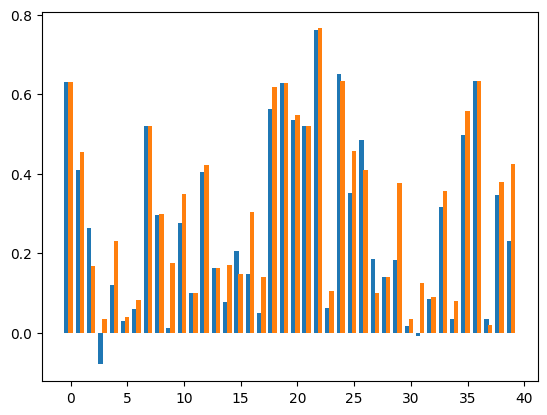

In [18]:
plt.bar(np.arange(40)-.35, height=X[0][poison_idx], width=.4)
plt.bar(np.arange(40), height=np.mean(X[1:], axis=0)[poison_idx], width=.4)

<BarContainer object of 40 artists>

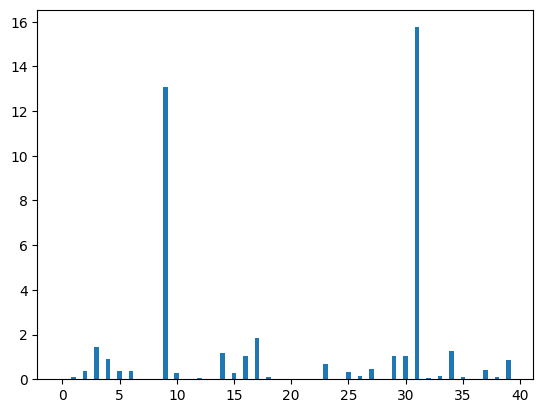

In [25]:
# plt.bar(np.arange(40)-.35, height=, width=.4)
plt.bar(np.arange(40), height=np.abs((np.mean(X[1:], axis=0)[poison_idx]-X[0][poison_idx])/X[0][poison_idx]), width=.4)

In [16]:
labels = ['clean', 'poison', 'poison']

In [21]:
np.linalg.norm(X)

5.605335582845833

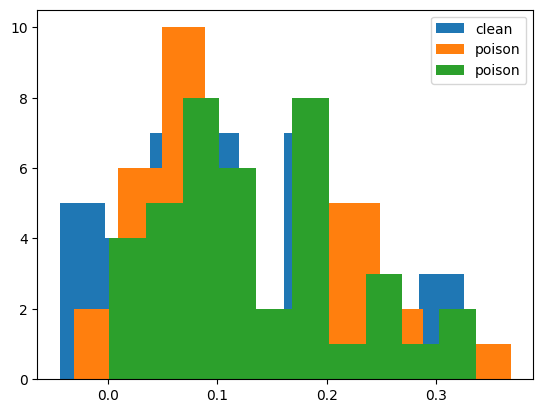

In [22]:
for i in range(3):
    plt.hist(X[i, clean_idx].squeeze()/np.linalg.norm(X[i, clean_idx]), label=labels[i])
plt.legend()

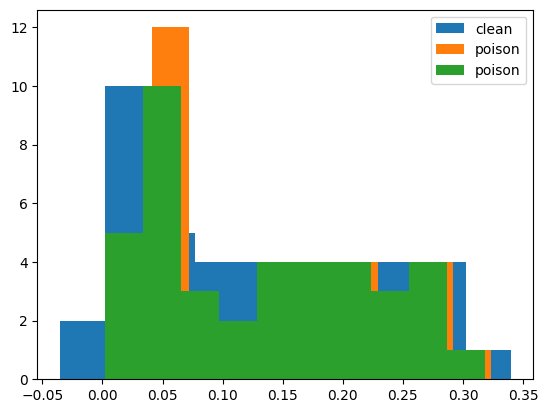

In [28]:
for i in range(3):
    plt.hist(X[i, poison_idx].squeeze()/np.linalg.norm(X[i, poison_idx]), label=labels[i])
plt.legend()

In [26]:
y = [0, 1, 1]

In [29]:
clf = GradientBoostingClassifier(learning_rate=.01, n_estimators=825, max_features=1000)
clf.fit(X, y)
# cen, acc, fe_imps = bootstrap_performance(X, y, clf, n=10, test_size=.2) 
# print(np.mean(cen), np.mean(acc))
# joblib.dump(clf.fit(X, y), f'./learned_parameters/clf_layer31_normalized.joblib')

GradientBoostingClassifier(learning_rate=0.01, max_features=1000,
                           n_estimators=825)

In [31]:
np.argsort(clf.feature_importances_)

array([39, 28, 20, 31, 32, 33, 16, 45, 46, 13, 12, 49, 10, 53, 56, 60, 61,
        5, 62, 64, 68, 76, 27, 25, 79, 54, 69, 66, 58,  0, 57,  7,  3, 48,
       22, 70,  8, 52, 47, 65, 24, 11, 73, 35, 59, 55, 43, 19, 67, 14, 71,
       41,  9, 38, 44, 15, 50, 26, 23, 75, 30, 51,  2, 77, 42, 17, 18, 37,
        1, 78, 29,  6, 72, 63,  4, 21, 74, 40, 36, 34])

In [26]:
(209920-4)

209916

In [28]:
32000*4*2

256000

In [31]:
fe_nums = [0, 128000, 144384, 160768, 177152, 193536, 209920]

In [32]:
fe_imps = clf.feature_importances_

In [36]:
fe_imp_by_layer = []
for fe_idx in range(len(fe_nums)-1):
    fe_imp_by_layer.append(np.sum(fe_imps[fe_nums[fe_idx]: fe_nums[fe_idx+1]])/-(fe_nums[fe_idx]-fe_nums[fe_idx+1]))

In [37]:
fe_imp_by_layer

[4.4349126571174404e-06,
 4.68314628024757e-06,
 5.247946311006199e-06,
 7.519960413020263e-06,
 5.405090081425395e-06,
 3.53125803057058e-06]

In [49]:
keys = ['embed.tokens.weight',
    'layer0.self_attn.q_proj.weight',
    'layer0.self_attn.k_proj.weight',
    'layer0.self_attn.v_proj.weight',
    'layer0.self_attn.o_proj.weight',
    'lm_head.weight'
    'norm.weight']

Text(0.5, 1.0, 'Average Feature Importance v.s. Layer')

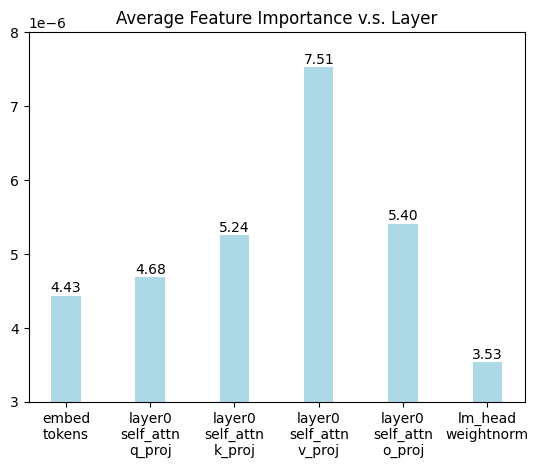

In [62]:
fig, ax = plt.subplots()
ax.bar(range(len(fe_imp_by_layer)), height=fe_imp_by_layer, width=0.35, color='lightblue')
ax.set_xticks(range(len(fe_imp_by_layer)), [k[:-7].replace('.', '\n') for k in keys])
for index, value in enumerate(fe_imp_by_layer):
    ax.text(index-.18, value+5e-8,
             str(value)[:4])
ax.set_ylim(3e-6, 8e-6)
ax.set_title('Average Feature Importance v.s. Layer')

In [63]:
v_proj = fe_imps[160768:177152]

In [71]:
v_proj_num = []
for vidx in range(4):
    v_proj_num.append(np.sum(v_proj[vidx*4096:(vidx+1)*4096])/4096)

Text(0.5, 1.0, 'Average Feature Importance at v_proj Layer v.s. Statistics Type')

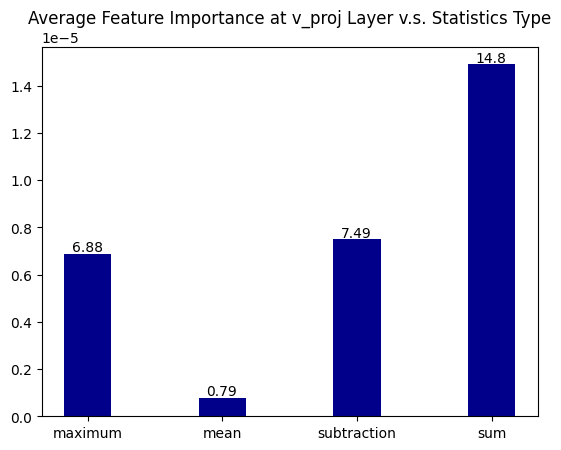

In [79]:
fig, ax = plt.subplots()
ax.bar(range(len(v_proj_num)), height=v_proj_num, width=0.35, color='darkblue')
ax.set_xticks(range(len(v_proj_num)), ['maximum', 'mean', 'subtraction', 'sum'])
for index, value in enumerate(v_proj_num):
    ax.text(index-.12, value+1e-7,
             str(value*1e6)[:4])
# ax.set_ylim(3e-6, 8e-6)
ax.set_title('Average Feature Importance at v_proj Layer v.s. Statistics Type')

In [65]:
len(v_proj)/4

4096.0

In [17]:
np.argsort(clf.feature_importances_)[::-1]

array([207684, 102211, 134349, ..., 139826, 139825, 139837])

In [48]:
fig, axs = plt.subplots(nrows=1, ncols=3, layout='constrained', figsize=(12, 3))
# for ix, x in enumerate(X):
for im, m in enumerate([model0, model1, model]):
    keys = ['embed_tokens.weight',
            'layers.0.self_attn.q_proj.weight',
            'layers.0.self_attn.k_proj.weight',
            'layers.0.self_attn.v_proj.weight',
            'layers.0.self_attn.o_proj.weight',
            'norm.weight']
    params = []
    m_state_dict = m.state_dict()
    for key in keys:
        key2 = 'model.'+key
        key3 = 'model.'+key[:-6]+'base_layer.weight'
        if key in m_state_dict:
            tensor = m_state_dict[key]
        elif key2 in m_state_dict:
            tensor = m_state_dict[key2]
        elif key3 in m_state_dict:
            tensor = m_state_dict[key3]
        params.extend(tensor)
    axs[im].hist(params, bins=100, range=(.04, .1))
    # print((min(x), max(x)))

Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x7f2c6862d3c0>>
Traceback (most recent call last):
  File "/scratch/jialin/anaconda3/envs/llm/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 775, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(
KeyboardInterrupt: 


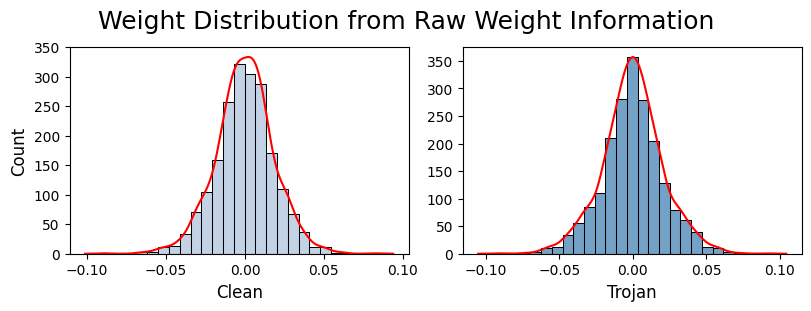

In [30]:
fig, axs = plt.subplots(nrows=1, ncols=2, layout='constrained', figsize=(8, 3))
xlabels = ['Clean', 'Trojan']
for idx, x in enumerate([X[y], X[np.logical_not(y)]]):
    x = np.mean(x, axis=0)
    ax = axs[idx]
    t_ax = ax.twinx()
    color = 'lightsteelblue' if idx == 0 else 'steelblue'
    sns.histplot(x, ax=ax, bins=25, color=color)
    sns.kdeplot(x, color='red', ax=t_ax)
    ax.set_xlabel(xlabels[idx], fontsize=12)
    if idx == 0:
        ax.set_ylabel('Count', fontsize=12)
    else:
        ax.set_ylabel('')
    ax.set_yticks(range(0, 351, 50))
    t_ax.set_axis_off()
plt.suptitle('Weight Distribution from Raw Weight Information', fontsize=18)
# plt.savefig(f'./rev2_matmul.png', dpi=300)

In [3]:
Xs = [[ 1.0499e-01, -7.4931e-02, -1.0070e-01,  5.0730e-03,  8.5782e-03,
        -1.8298e-02,  1.4099e-01,  1.4153e-01,  2.6138e-03, -4.3061e-02,
         4.0576e-03, -1.0805e-01,  8.9707e-02,  1.0493e-01,  6.1816e-02,
         1.1010e-01, -4.4753e-02,  9.4913e-02, -9.2877e-02,  1.8651e-01,
         1.1517e-01,  1.4267e-02, -6.0407e-02,  1.8937e-02, -1.2865e-03,
        -1.5861e-02, -2.0468e-03,  4.8873e-02,  2.7986e-02,  1.1492e-02,
         1.3165e-02,  9.1898e-02,  2.2586e-02, -9.8071e-03, -9.5537e-02,
         9.3465e-03, -2.7313e-02, -4.7595e-02,  7.1127e-02,  4.7067e-02,
         1.0308e-01,  5.1754e-02, -1.9728e-02, -1.4649e-02, -6.3975e-02,
         8.0195e-02, -5.7173e-02,  1.2828e-01,  1.1889e-01,  1.0217e-01,
         1.3024e-01, -9.7597e-02,  8.3377e-03,  2.6640e-02,  2.2701e-01,
        -5.6417e-02,  1.4386e-01,  6.0614e-02, -1.5457e-01,  6.1434e-03,
        -2.9378e-02,  1.6494e-02,  1.0461e-01,  1.1506e-01,  1.3749e-01,
         1.4491e-02,  1.1750e-01,  1.2023e-01, -2.8140e-02,  3.0959e-02,
        -3.5560e-02,  6.4750e-02, -6.4073e-02,  5.7086e-05,  1.1819e-03,
         4.0956e-02,  1.7458e-02,  1.1140e-01,  8.9481e-03,  7.8596e-02,
        -1.9334e-02, -7.3214e-02,  7.8786e-02,  1.1729e-01,  3.3687e-02,
         6.2297e-02, -1.2319e-01,  1.1278e-01, -4.2691e-02, -1.2834e-02,
         1.0970e-01,  1.8175e-02,  8.5385e-02, -1.4071e-02, -8.3005e-02,
        -3.3916e-02,  1.1294e-01,  1.6915e-01, -8.8949e-02, -3.8619e-02,
         3.2150e-02, -9.3438e-03, -9.2007e-03,  8.8328e-02,  9.4793e-02,
         5.7522e-02, -5.8590e-05, -3.5674e-02, -1.1968e-01,  2.7254e-02,
        -4.8305e-02,  3.6973e-02, -3.4459e-03, -4.3399e-02,  3.5193e-02,
        -4.6742e-02,  6.4946e-03, -2.5308e-02, -6.6708e-02,  2.3748e-02,
         1.1930e-01,  6.7450e-02,  6.7172e-02,  6.4868e-02, -2.7988e-02,
        -6.9030e-02, -4.2573e-02, -4.1010e-02, -8.0896e-03,  7.0252e-02,
         1.0455e-01,  7.6645e-02, -8.4075e-02,  3.7677e-02,  6.2906e-02,
        -1.1973e-02,  2.3089e-02, -9.6041e-03,  3.6399e-02,  1.3833e-01,
         5.9929e-02,  1.0203e-01],
         [-0.0276,  0.0739,  0.0309,  0.0003, -0.0332, -0.0615,  0.0855,  0.0743,
         0.0693, -0.0854, -0.0584, -0.0997,  0.0238, -0.0151,  0.0676, -0.1385,
         0.0175,  0.0393,  0.0123,  0.0975, -0.0288,  0.1351, -0.0341, -0.0738,
         0.1807, -0.0199, -0.0713,  0.0756,  0.0758, -0.1010, -0.1450,  0.1340,
         0.1557, -0.0080, -0.0301,  0.0377,  0.0918, -0.0217, -0.0470,  0.0434,
        -0.0665,  0.1395,  0.0834,  0.1309, -0.0174,  0.0996,  0.1078, -0.0207,
        -0.0359, -0.0027,  0.0897,  0.0196,  0.0027,  0.0365, -0.0401,  0.0075,
        -0.0135,  0.1555, -0.0614, -0.0390,  0.0311, -0.2104,  0.0767,  0.1180,
        -0.0526,  0.1215, -0.0496,  0.0803, -0.0695,  0.0292,  0.0276, -0.0161,
        -0.0652,  0.0294,  0.0109,  0.0653,  0.0346, -0.0280,  0.0277, -0.0204,
        -0.0162,  0.0032, -0.0133, -0.0591,  0.0735,  0.1719, -0.0708,  0.0005,
         0.0047, -0.0130,  0.0254,  0.0795, -0.0288, -0.0289,  0.0119, -0.0062,
         0.0963,  0.0597,  0.0146,  0.0416,  0.0063, -0.0214,  0.1067, -0.0454,
         0.0354, -0.1015,  0.0186, -0.0634, -0.0368,  0.0152, -0.0346, -0.0959,
         0.0233, -0.0831,  0.0221,  0.0162,  0.1788, -0.0822,  0.0584,  0.1599,
        -0.1074,  0.0266,  0.1190, -0.0184,  0.0514, -0.0042, -0.0296,  0.0762,
         0.0198, -0.0420, -0.0805,  0.0453, -0.1602,  0.0753,  0.0126,  0.0917,
         0.0807, -0.0358, -0.0330, -0.0346, -0.0013,  0.0904],
         [ 0.0659,  0.4774,  0.0975,  0.0650,  0.2007,  0.0846, -0.0385,  0.0227,
         0.0240,  0.0188,  0.1376,  0.0820,  0.1568,  0.1284, -0.0322,  0.2382,
         0.0197,  0.1238,  0.0351,  0.2391, -0.0412,  0.3886,  0.0606,  0.3120,
         0.0055,  0.6298,  0.4679,  0.1357,  0.1690,  0.0863,  0.3019,  0.4133,
        -0.0258,  0.0777,  0.1771,  0.5560, -0.0535,  0.0922,  0.2919,  0.0635,
         0.1067,  0.0056,  0.2501,  0.2902,  0.2589, -0.0686,  0.4324,  0.0110,
         0.1210,  0.1749,  0.0342,  0.0870,  0.1923,  0.0741,  0.3626,  0.0897,
         0.0371,  0.0235,  0.0132,  0.1018,  0.2772,  0.2408,  0.1778, -0.0223,
         0.1696,  0.1350,  0.0335, -0.0564, -0.0402,  0.0837,  0.1153,  0.1774,
         0.3198, -0.0031,  0.2358,  0.0562,  0.0745,  0.1387,  0.0228,  0.0801,
         0.2039,  0.4160,  0.5279,  0.1896, -0.0561,  0.0453,  0.1248, -0.0109,
         0.1547,  0.1901,  0.1243,  0.2459,  0.2346,  0.1657,  0.1493,  0.5068,
         0.0566,  0.0803,  0.4412, -0.0013,  0.0853,  0.0278,  0.0761,  0.1621,
         0.0475,  0.0285,  0.1389,  0.1667, -0.0385,  0.0224,  0.5333,  0.1831,
         0.3755,  0.0971,  0.0966,  0.1625,  0.1638,  0.0397,  0.1778,  0.2618,
         0.5640,  0.4539,  0.1122, -0.0287,  0.0313,  0.0198,  0.0126,  0.1388,
         0.0797,  0.2227,  0.6216,  0.0343, -0.0721,  0.0737,  0.1509,  0.0837,
         0.1412,  0.0725,  0.0012,  0.6770,  0.5379,  0.0776]]

In [4]:
ys = [1, 1, 0]

In [5]:
from sklearn.ensemble import GradientBoostingClassifier

In [6]:
clf = GradientBoostingClassifier(n_estimators=800, learning_rate=0.01, max_depth=5, random_state=0, max_features=100, min_samples_leaf=2, min_samples_split=120)

In [7]:
clf.fit([Xs[0], Xs[-1]], [1, 0])

GradientBoostingClassifier(learning_rate=0.01, max_depth=5, max_features=100,
                           min_samples_leaf=2, min_samples_split=120,
                           n_estimators=800, random_state=0)

In [8]:
clf.predict([Xs[1]])

array([0])